# Working directories

We assume the following directory structure is created. Do not change it. First read instructions at [GitHub](https://github.com/artur-gramacki/Epileptic-Seizure-Detection).
```
   |---annotations
   |---edf
   |---Python
   |---R
       |---test_files
   |---working
     |---acc_loss
     |---best_models
     |---hists
     |---inputs
     |---logs
     |---results    
     |---ROC
     |---waveforms
```


# Global variables

Set correct values for `WRK_RIR`, `INPUT_DIR` and `GOOGLE_COLAB` global variables, according to your environment.

The `COMPLETE_CALCULATIONS` should be set to `False` for the first use. If you set it to `True`, complete calculations will take and this is a very time consuming task (many hours or even days). To familiarize yourself with this notebook, we suggest that you first run it with the `COMPLETE_CALCULATIONS` variable set to `False`. Leave the other variables unchanged if you use input data provided by us (HDF5 files in the `../working/inputs` directory)

**Then you can safely run all the code cells (Ctrl+F9 in Google Colab).**

In [ ]:
# 'working' and 'working/inputs' dirs are fixed in the R codes, do not change them.
WRK_DIR = '/content/drive/MyDrive/Colab Notebooks/EEG_neonatal/__codes__and__data__/working/'
INPUT_DIR = '/content/drive/MyDrive/Colab Notebooks/EEG_neonatal/__codes__and__data__/working/inputs/'

# Set to False if you are not using Google Colab.
GOOGLE_COLAB = True

# A complete set of calculations will be performed if the below variable is set to True.
# NOTE: complete calculations will take --MANY HOURS, EVEN DAYS--!
# The GPU card is absolutely essential.
# Without it, don't even try to start complete calculations.
COMPLETE_CALCULATIONS = False

# Used in 'train_test_split' and  'StratifiedKFold' functions to ensure reproducible results.
SEED = 1024

# Frequency of the input hdf5 files (stored in the 'inputs' directory).
# For the purpose of the paper, the EDF files were down-sampled to 64Hz.
# Therefore, do not change this value unless you regenerate new hdf5 files
# in R with a value other than 64 Hz.
FREQ = 64

# See an example 'expert_A_1sec_1chunk_64Hz.txt' file which presents the desired input data structure.
# This file contains exactly the same data as are stored in 'expert_A_1sec_1chunk_64Hz.hdf5' file.
# HDF5 format was chosen because it is an ideal choice for storing and organizing large amounts of data.
#
# Number of EEG signals in the HDF5 file
NO_OF_EEG_CHANELS = 18
# Column number in the HDF5 file where class indicator is written
SEIZURE_INDICATOR = 20

print(WRK_DIR)
print(INPUT_DIR)
print(SEED)

/content/drive/MyDrive/Colab Notebooks/EEG_neonatal/__codes__and__data__/working/
/content/drive/MyDrive/Colab Notebooks/EEG_neonatal/__codes__and__data__/working/inputs/
1024


# Drive mount in Colab
Run this code cell only if your working environment is Google Colaboratory.

In [ ]:
if GOOGLE_COLAB:
    from google.colab import drive
    drive.mount("/content/drive/")

Mounted at /content/drive/


# GPU info
Run this code cell only if your working environment is Google Colaboratory.

First check if GPU is available in your Google account (GPU usage limits vary over time).

See https://research.google.com/colaboratory/faq.html for details.

NOTE: without access to the GPU, calculations will be unacceptably long.

In [ ]:
if GOOGLE_COLAB:
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('No GPU available')
    else:
        print(gpu_info)

Wed Apr 20 08:11:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Clearing the directory contents
Uncomment the below `rm` and `mkdir` commands to clear the content of these directories. **Use with caution!**

The `inputs` directory must contain the HDF5 data files for the CNN network. These files are regenerated in R.

If you are working in Windows, change the Linux-like command for Windows-like equivalents.


In [ ]:
#!rm -rf "$WRK_DIR/acc_loss"
#!rm -rf "$WRK_DIR/best_models"
#!rm -rf "$WRK_DIR/hists"
#!rm -rf "$WRK_DIR/logs"
#!rm -rf "$WRK_DIR/results"
#!rm -rf "$WRK_DIR/ROC"
#!rm -rf "$WRK_DIR/waveforms"

#!mkdir "$WRK_DIR/acc_loss"
#!mkdir "$WRK_DIR/best_models"
#!mkdir "$WRK_DIR/hists"
#!mkdir "$WRK_DIR/logs"
#!mkdir "$WRK_DIR/results"
#!mkdir "$WRK_DIR/ROC"
#!mkdir "$WRK_DIR/waveforms"

print("DONE")

DONE


In [ ]:
#!ls -la "$WRK_DIR/acc_loss"
#!ls -la "$WRK_DIR/best_models"
#!ls -la "$WRK_DIR/hists"
#!ls -la "$WRK_DIR/logs"
#!ls -la "$WRK_DIR/inputs"
#!ls -la "$WRK_DIR/results"
#!ls -la "$WRK_DIR/ROC"
#!ls -la "$WRK_DIR/waveforms"

print("DONE")

DONE


# TensorBoard

Check if TensorBoard is working properly in your working environment. For example in Kaggle it does not start correctly (a bit unexpectedly).

In [ ]:
#Start by installing TF 2.0 and loading the TensorBoard notebook extension:
#!pip install -q tf-nightly-2.0-preview
# Load the TensorBoard notebook extension
# !kill 2604
%load_ext tensorboard

# Uncomment to clear
#!rm -rf "$WRK_DIR/logs/"
#!mkdir  "$WRK_DIR/logs/"
TBDIR = WRK_DIR + "logs/"
%tensorboard --logdir "$TBDIR"

print(TBDIR)

# Imports

In [ ]:
# TensorFlow and tf.keras
# https://pypi.org/project/silence-tensorflow/
# Genialny pakiet, który wyłacza wszystkie wnerwiające warning-i i inne "badziewia" pojawiające się w konsoli.
# Simple python package to shut up Tensorflow warnings and logs.
# You only need to import the package __BEFORE__ import Tensorflow:
#
# In Colab this is not neccessary (all 'dirty warnings' are dissabled by default.)
if  not GOOGLE_COLAB:
    from silence_tensorflow import silence_tensorflow
    silence_tensorflow()

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import math
import h5py
import pickle
import time
import random
import os
import sklearn
import csv
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras import regularizers
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from random import randrange
from numpy import genfromtxt

print(tf.__version__ )

print("DONE")

2.8.0
DONE


# read_data function
We assume that the input data have the following format: `expert_XXX_YYYsec_ZZZchunk_VVVHz.hdf5` where:

- XXX - strings (values used in the paper are "A", "B" or "C")
- YYY - window size in sec (values used in the paper are 1, 2, 5, 10, 20)
- ZZZ - number of contiguous chunks (values used in the paper are 1, 2, 5, 10, 20, 10000)
- VVV - base frequency in the HDF5 file (value used in the paper is 64)


In [ ]:
def read_data(freq, which_expert, window, chunks, print_to_file = False):
    # freq - base frequency in .hdf5 file
    # which_expert - "A", "B" or "C"
    # window - sliding-window size
    # chunks - number of contiguous chunks

    freq = freq
    which_expert = which_expert
    window = window
    chunks = chunks

    data_name = "expert_{}_{}sec_{}chunk_{}Hz.hdf5".format(which_expert, window, chunks, freq)
    data_name_no_ext = os.path.splitext(data_name)[0]
    results_str = WRK_DIR + "results/results_" + data_name_no_ext + ".txt"

    if print_to_file:
        f = open(results_str, "a")
        print(data_name)
        print("########################################################", file = f)
        print("#", data_name, file = f)
        print("########################################################", file = f)

    ds = 1 # down sampling factor  (must be divisible by "freq", that is, 1,2,4,8 etc. In practice no more than 4, 1 - no down-sampling)
           # While preparing our hdf5 files in R, they have already gone through the down sampling procedure (256Hz --> 64Hz).
           # Therefore, we set ds = 1 here.
    size = int(freq * window / ds)

    file_h5 = h5py.File(INPUT_DIR + data_name, "r")
    list(file_h5.keys())
    temp = file_h5["FINAL.mtx"]
    temp = np.array(temp)
    # Transposition is needed here. In hdf5 file rows and columns are swapped
    dd = np.transpose(temp)
    dd.shape

    ddss = dd[::ds]
    ddss.shape
    dr = ddss.reshape(int(ddss.shape[0] / size), size, dd.shape[1])
    dr.shape

    # See 'Global variables' block
    x = dr[:,:,0:NO_OF_EEG_CHANELS]
    x.shape
    # '-1' as in Python indexing starts from 0
    y = dr[:,0,SEIZURE_INDICATOR - 1]
    y.shape

    # Normalization
    x = tf.keras.utils.normalize(x, axis = 1)

    if print_to_file:
        # print("dd:", dd.shape, file = f)
        print("Input matrix dims:", ddss.shape, file = f)
        print("x:", x.shape, file = f)
        print("y:", y.shape, file = f)
        f.close()

    return x, y, data_name

print("DONE")

DONE


# build_CNN_model function

In [ ]:
def get_function_name():
    import inspect
    return inspect.stack()[1][3]

def build_CNN_model(my_shape):
    description = get_function_name()
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape = my_shape[1:]),
            tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), strides = (1, 1), padding = "same", name = "conv2d_1"),
            tf.keras.layers.BatchNormalization(name = "batch_normalization_1"),
            tf.keras.layers.Activation("relu", name = "activation_relu_1"),
            tf.keras.layers.MaxPooling2D(pool_size = (2, 2), name = "max_pooling2d_1"),
            tf.keras.layers.Dropout(0.25, name = "dropout_1"),

            tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), padding = "same", name = "conv2d_2"),
            tf.keras.layers.BatchNormalization(name = "batch_normalization_2"),
            tf.keras.layers.Activation("relu", name = "activation_relu_2"),
            tf.keras.layers.MaxPooling2D(pool_size = (2, 2), name = "max_pooling2d_2"),
            tf.keras.layers.Dropout(0.25, name = "dropout_2"),

            tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), strides = (1, 1), padding = "same", name = "conv2d_3"),
            tf.keras.layers.BatchNormalization(name = "batch_normalization_3"),
            tf.keras.layers.Activation("relu", name = "activation_relu_3"),
            tf.keras.layers.MaxPooling2D(pool_size = (2, 2), name = "max_pooling2d_3"),

            tf.keras.layers.Dropout(0.5, name = "dropout_3"),
            tf.keras.layers.Flatten(name = "flatten"),
            tf.keras.layers.Dense(32, activation = "relu", kernel_regularizer = regularizers.l2(l2 = 0.001), name = "dense_1"),
                #kernel_regularizer = regularizers.l1_l2(l1 = 1e-5, l2 = 1e-4),
                #bias_regularizer = regularizers.l2(1e-4),
                #activity_regularizer = regularizers.l2(1e-5)),
            tf.keras.layers.Dropout(0.5, name = "dropout_4"),
            tf.keras.layers.Dense(64, activation = "relu", kernel_regularizer = regularizers.l2(l2 = 0.001), name = "dense_2"),
                #kernel_regularizer = regularizers.l1_l2(l1 = 1e-5, l2 = 1e-4),
                #bias_regularizer = regularizers.l2(1e-4),
                #activity_regularizer = regularizers.l2(1e-5)),
            tf.keras.layers.Dense(1, activation = "sigmoid", name = "dense_3"),
        ]
    )

    model.compile(
        optimizer = SGD(learning_rate = 0.01, momentum = 0.5, decay = 0.0, nesterov = False),
        loss = "binary_crossentropy",
        metrics = ["acc"]
    )
    return model, description

print("DONE")

DONE


# CNN_fit_eval_pred function

In [ ]:
def CNN_fit_eval_pred(x, y, data_name, kfold = True, patience = 10000):
    # patience: Number of epochs with no improvement after which training will be stopped.
    # 10000 means in fact that early stopping will not take place.
    best_model_score_validate = []
    best_model_score_test = []

    # Extract test data
    # random_state used to make the results repeatable
    x2, x_test, y2, y_test = train_test_split(x, y, test_size = 0.2, shuffle = True, random_state = SEED)
    folds = list(StratifiedKFold(n_splits = 5, shuffle = True, random_state = SEED).split(x2, y2))

    if kfold:
        n = len(folds)
    else:
        n = 1

    # Remove extension filename
    data_name_no_ext = os.path.splitext(data_name)[0]
    results_str = WRK_DIR + "results/results_" + data_name_no_ext + ".txt"

    # New version, if kfold parameter IS supported
    for fold_number in range(n):
        print("Fold: ", fold_number)
        print(time.strftime("%d-%m-%Y %H:%M:%S", time.localtime()))
        x_train_cv = x2[folds[fold_number][0]]
        y_train_cv = y2[folds[fold_number][0]]
        x_validate_cv = x2[folds[fold_number][1]]
        y_validate_cv = y2[folds[fold_number][1]]

    # Old version, if kfold parameter WAS NOT supported
    #for fold_number, (train_idx, validate_idx) in enumerate(folds):
        #print("Fold: ", fold_number)
        #print(time.strftime("%d-%m-%Y %H:%M:%S", time.localtime()))
        #x_train_cv = x2[train_idx]
        #y_train_cv = y2[train_idx]
        #x_validate_cv = x2[validate_idx]
        #y_validate_cv = y2[validate_idx]

        f = open(results_str, "a")

        if fold_number == 0:
            print("x_train_cv:", x_train_cv.shape, "\nx_validate_cv:", x_validate_cv.shape, "\nx_test:", x_test.shape, file = f)
            print("y_train_cv:", y_train_cv.shape, "\ny_validate_cv:", y_validate_cv.shape, "\ny_test:", y_test.shape, file = f)
            print("\n", file = f)

        print("\nFold: ", fold_number, file = f)

        f.close()

        my_shape = np.expand_dims(x, axis = 3).shape
        my_shape[1:]
        model, model_description = build_CNN_model(my_shape)

        #####################################################################
        # add dimmension for conv2d
        #####################################################################
        x_train_3d = x_train_cv
        x_train_3d = np.expand_dims(x_train_3d, axis = 3)

        x_validate_3d = x_validate_cv
        x_validate_3d = np.expand_dims(x_validate_3d, axis = 3)

        x_test_3d = x_test
        x_test_3d = np.expand_dims(x_test_3d, axis = 3)

        # Creat list of callbacks
        # https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/
        # Drop-Based Learning Rate Schedule
        def drop_based_step_decay(epoch):
            # epoch is the current epoch number
            initial_lrate = 0.1
            drop = 0.75  # the amount that the learning rate is modified each time it is changed
            epochs_drop = 10.0 # how often to change the learning rate
            lrate = initial_lrate * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
            return lrate

        # Time-Based Learning Rate Schedule
        def time_based_step_decay(epoch):
            initial_lrate = 0.1
            decay = 0.1
            lrate = initial_lrate * 1 / (1 + decay * epoch)
            return lrate

        best_model_str = WRK_DIR + "best_models/best_model_{}_fold_{}.hdf5".format(data_name_no_ext, fold_number)
        best_model_str_2 = "best_model_{}_fold_{}.hdf5".format(data_name_no_ext, fold_number)
        TensorBoard_log = WRK_DIR + "logs/TensorBoard_log_{}_fold_{}".format(data_name_no_ext, fold_number)
        history_csv_str = WRK_DIR + "hists/history_{}_fold_{}.csv".format(data_name_no_ext, fold_number)
        history_pickle_str = WRK_DIR + "hists/history_{}_fold_{}.pckl".format(data_name_no_ext, fold_number)


        callbacks = [
            # patience: Number of epochs with no improvement after which training will be stopped
            tf.keras.callbacks.EarlyStopping(monitor = "val_acc", patience = patience, verbose = 1),
            # If L1 or L2 or L1/L2 is used, LearningRateScheduler works not so good
            # tf.keras.callbacks.LearningRateScheduler(drop_based_step_decay),
            # tf.keras.callbacks.LearningRateScheduler(time_based_step_decay),
            tf.keras.callbacks.ModelCheckpoint(
                filepath = best_model_str,
                monitor = "val_acc",
                save_best_only = True),
            tf.keras.callbacks.TensorBoard(
                log_dir = TensorBoard_log,
                histogram_freq = 0,  # it has to be 0, otherwise throws error during training
                write_graph = True,
                write_images = True,
            )
            ]

        # Training time
        start = time.time()

        if GOOGLE_COLAB:
            # Read GPU ID
            gpu_info = !nvidia-smi -L

        history = model.fit(
            x_train_3d,
            y_train_cv,
            epochs = 300,
            batch_size = 16,
            callbacks = callbacks,
            validation_data = (x_validate_3d, y_validate_cv),
            verbose = 1,
        )

        end = time.time()

        # Convert the history.history dict to a pandas DataFrame.
        history_df = pd.DataFrame(history.history)
        with open(history_csv_str, mode = 'w') as ff:
            history_df.to_csv(ff)
            ff.close()

        with open(history_pickle_str, 'wb') as ff:
            pickle.dump(history.history, ff)
            ff.close()

        f = open(results_str, "a")

        print("Time: ", int(end - start) // 60, "m ", int(end - start) % 60,  "s", sep = "", file = f)

        if GOOGLE_COLAB:
            print(gpu_info, file = f)

        print(best_model_str_2, file = f)

        # Loading the weights of the best model and checking its effectiveness (validate and test data).
        model.load_weights(best_model_str)
        best_model_score_validate.append(model.evaluate(x_validate_3d, y_validate_cv, batch_size = 16, verbose = 0))
        print("--Best model validation accuracy: %.2f%%" % (best_model_score_validate[fold_number][1] * 100), file = f)

        best_model_score_test.append(model.evaluate(x_test_3d, y_test, batch_size = 16, verbose = 0))
        print("--Best model test accuracy: %.2f%%" % (best_model_score_test[fold_number][1] * 100), file = f)

        # Confusion matrix & stuff
        mpl.rcParams['figure.figsize'] = (10, 10)
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        predictions = model.predict(x_test_3d, verbose = 1)
        name = data_name_no_ext + '_fold_' + str(fold_number) + ".png"
        plot_roc_curve(name, y_test, predictions, save_to_file = True, color = colors[0])
        print('Confusion matrix:', file = f)
        cm = confusion_matrix(y_test, predictions > 0.5)
        cmdf = pd.DataFrame(
            confusion_matrix(y_test, predictions > 0.5, labels = [0, 1]),
            index = ['true: seizure', 'true: no seizure'],
            columns = ['pred: seizure', 'pred: no seizure']
        )
        print(cmdf, file = f)
        precision = cm[0, 0] / (cm[0, 0] + cm[1, 0])
        recall = cm[0, 0] / (cm[0, 0] + cm[0, 1])
        F_measure = 2 * ((precision * recall) / (precision + recall))
        out = 'Precision: ' + str(round(precision, 2))
        print(out, file = f)
        out = 'Recall: ' + str(round(recall, 2))
        print(out, file = f)
        out = 'F-measure: ' + str(round(F_measure, 2))
        print(out, file = f)

        f.close()

        accuracy_validate = [row[1] for row in best_model_score_validate]
        accuracy_test = [row[1] for row in best_model_score_test]

    avg_accuracy_validate = np.mean(accuracy_validate)
    avg_accuracy_test = np.mean(accuracy_test)

    f = open(results_str, "a")

    print("\n--Best models AVARAGE validation accuracy: %.2f%%" % (avg_accuracy_validate * 100), file = f)
    print("--Best models AVARAGE test accuracy: %.2f%%" % (avg_accuracy_test * 100), file = f)

    print("\n", file = f)

    f.close()

print("DONE")

DONE


# plot_* functions

In [ ]:
def plot_roc_curve(name, labels, predictions, save_to_file = False, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions, pos_label = 1, drop_intermediate = False)
    auc_score = roc_auc_score(labels, predictions)
    auc_score_text = 'AUC = ' + str(round(auc_score, 2))
    plt.plot(100 * fp, 100 * tp, label = name, linewidth = 2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-1, 101])
    plt.ylim([-1, 101])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.legend(loc='lower right')
    plt.text(60, 20, auc_score_text, fontsize = 22)
    fig_str = WRK_DIR + "ROC/ROC_" + name
    if save_to_file:
        plt.savefig(fig_str)
        plt.clf()


def plot_pr_curve(name, labels, predictions, save_to_file = False, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions, pos_label = 1)
    plt.plot(precision, recall, label = name, linewidth = 2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.xlim([-0.1, 1.1])
    plt.ylim([-0.1, 1.1])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.legend(loc='lower right')
    fig_str = WRK_DIR + "ROC/PR_" + name
    if save_to_file:
        plt.savefig(fig_str)
        plt.clf()

def plot_acc_loss(file_name, history, title = "", save_to_file = False):
    fig, (ax1, ax2) = plt.subplots(2)
    fig.set_size_inches(8, 8)

    acc = history["acc"]
    val_acc = history["val_acc"]
    loss = history["loss"]
    val_loss = history["val_loss"]
    epochs = range(1, len(acc) + 1)

    ax1.grid(True)
    ax1.plot(epochs, acc, "r", label = "Training acc")
    ax1.plot(epochs, val_acc, "b", label = "Validation acc")
    ax1.set_title(title + "\nTraining and validation accuracy")
    ax1.set(xlabel = 'Epochs', ylabel = 'Accuracy')
    ax1.legend()

    ax2.grid(True)
    ax2.plot(epochs, loss, "r", label = "Training loss")
    ax2.plot(epochs, val_loss, "b", label = "Validation loss")
    ax2.set_title("Training and validation loss")
    ax2.set(xlabel = 'Epochs', ylabel = 'Loss')
    ax2.legend()

    fig.tight_layout()
    if save_to_file:
        fig_str = WRK_DIR + "acc_loss/acc_loss_" + file_name
        plt.savefig(fig_str)
        plt.clf()

print("DONE")

DONE


# Checking if all HDF5 files are readable

In [ ]:
freq = FREQ

if COMPLETE_CALCULATIONS:
    which_expert = np.array (["A", "B", "C"])
    windows = [1, 2, 5, 10, 20]
    chunks = [1, 2, 5, 10, 20, 10000]
else:
    which_expert = np.array (["A"])
    windows = [1]
    chunks = [1]

i = 1
for we in which_expert:
    for w in windows:
        for c in chunks:
            x, y, data_name = read_data(freq = FREQ, which_expert = we, window = w, chunks = c, print_to_file = False)
            data_name = "expert_{}_{}sec_{}chunk_{}Hz.hdf5".format(we, w, c, freq)
            print(i, data_name, '--> OK')
            i = i + 1

1 expert_A_1sec_1chunk_64Hz.hdf5 --> OK


# \_\_Run\_\_

Change `windows` and `chunks` for the desired values.

In the paper the following values have been used: `windows = [1, 2, 5, 10, 20] ` and `chunks = [1, 2, 5, 10, 20, 10000]`.

As a trial, we suggest that you enter `windows = [1]`, `chunks = [1]` and `which_expert = np.array (["A"])` at the beginning.


In [ ]:
if COMPLETE_CALCULATIONS:
    which_expert = np.array (["A", "B", "C"])
    windows = [1, 2, 5, 10, 20]
    chunks = [1, 2, 5, 10, 20, 10000]
    kfold = True
else:
    # For fast testing only
    which_expert = np.array (["A"])
    windows = [1]
    chunks = [1]
    kfold = False

for we in which_expert:
    for w in windows:
        for c in chunks:
            x, y, data_name = read_data(freq = FREQ, which_expert = we, window = w, chunks = c, print_to_file = True)
            print(x.shape)
            print(y.shape)
            if c == 10000:
                # patience: Number of epochs with no improvement after which training will be stopped.
                # Since calculations for chunks = 10000 take a long time, in this case we allow earlier ending of calculations.
                CNN_fit_eval_pred(x = x, y = y, data_name = data_name, kfold = False, patience = 30)
            else:
                CNN_fit_eval_pred(x = x, y = y, data_name = data_name, kfold = kfold)

print("DONE")

expert_A_1sec_1chunk_64Hz.hdf5
(781, 64, 18)
(781,)
Fold:  0
20-04-2022 08:11:26
Epoch 1/300
32/32 [==============================] - 15s 115ms/step - loss: 0.8771 - acc: 0.4910 - val_loss: 0.7940 - val_acc: 0.5200
Epoch 2/300
32/32 [==============================] - 1s 16ms/step - loss: 0.8185 - acc: 0.5471 - val_loss: 0.7942 - val_acc: 0.5040
Epoch 3/300
32/32 [==============================] - 0s 15ms/step - loss: 0.8276 - acc: 0.4790 - val_loss: 0.7934 - val_acc: 0.5200
Epoch 4/300
32/32 [==============================] - 1s 16ms/step - loss: 0.7915 - acc: 0.5291 - val_loss: 0.7933 - val_acc: 0.5200
Epoch 5/300
32/32 [==============================] - 0s 15ms/step - loss: 0.7997 - acc: 0.5471 - val_loss: 0.7926 - val_acc: 0.5200
Epoch 6/300
32/32 [==============================] - 1s 16ms/step - loss: 0.7805 - acc: 0.5631 - val_loss: 0.7916 - val_acc: 0.5200
Epoch 7/300
32/32 [==============================] - 0s 15ms/step - loss: 0.8047 - acc: 0.5210 - val_loss: 0.7924 - val_acc: 

<Figure size 720x720 with 0 Axes>

# Visualize the model

In [ ]:
x, y, data_name = read_data(freq = FREQ, which_expert = "A", window = 1, chunks = 1, print_to_file = False)
my_shape = np.expand_dims(x, axis = 3).shape
model, model_description = build_CNN_model(my_shape)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 64, 18, 128)       1280      
                                                                 
 batch_normalization_1 (Batc  (None, 64, 18, 128)      512       
 hNormalization)                                                 
                                                                 
 activation_relu_1 (Activati  (None, 64, 18, 128)      0         
 on)                                                             
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 9, 128)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 32, 9, 128)        0         
                                                      

# Read history files and generate acc+loss plots, then save to files

In [ ]:
freq = FREQ

if COMPLETE_CALCULATIONS:
    which_expert = np.array (["A", "B", "C"])
    windows = [1, 2, 5, 10, 20]
    chunks = [1, 2, 5, 10, 20, 10000]
    folds = [0, 1, 2, 3, 4]
else:
    # For fast testing only
    which_expert = np.array (["A"])
    windows = [1]
    chunks = [1]
    folds = [0]

for we in which_expert:
    for w in windows:
        for c in chunks:
            for f in folds:
                # due to the very long computation times for chunks=10000 only one fold was computed
                if c == 10000:
                    f = 0
                hist_file_name = "history_expert_{}_{}sec_{}chunk_{}Hz_fold_{}.pckl".format(we, w, c, freq, f)
                hist_file_name_2 = "expert_{}_{}sec_{}chunk_{}Hz_fold_{}.png".format(we, w, c, freq, f)
                hist_file_title = "expert_{}_{}sec_{}chunk_{}Hz_fold_{}".format(we, w, c, freq, f)
                print(hist_file_name_2)
                with open(WRK_DIR + 'hists/' + hist_file_name, 'rb') as file:
                    history = pickle.load(file)
                    plot_acc_loss(hist_file_name_2, history, title = hist_file_title, save_to_file = True)

print("DONE")

expert_A_1sec_1chunk_64Hz_fold_0.png
DONE


<Figure size 576x576 with 0 Axes>

# Read best models and generate ROC curves, then save them to files

In [ ]:
freq = FREQ

accuracy_list = []
precision_list = []
recall_list = []
F_measure_list = []

if COMPLETE_CALCULATIONS:
    which_expert = np.array (["A", "B", "C"])
    windows = [1, 2, 5, 10, 20]
    chunks = [1, 2, 5, 10, 20, 10000]
    folds = [0, 1, 2, 3, 4]
else:
    # For fast testing only
    which_expert = np.array (["A"])
    windows = [1]
    chunks = [1]
    folds = [0]

start = time.time()

for we in which_expert:
    for w in windows:
        file = open(WRK_DIR + "results/results_test_data_evaluate_predict.txt", "a")
        for c in chunks:
            x, y, data_name = read_data(freq = FREQ, which_expert = we, window = w, chunks = c, print_to_file = False)
            x2, x_test, y2, y_test = train_test_split(x, y, test_size = 0.2, shuffle = True, random_state = SEED)
            x_test_3d = x_test
            x_test_3d = np.expand_dims(x_test_3d, axis = 3)

            my_shape = np.expand_dims(x, axis = 3).shape
            my_shape[1:]
            model, model_description = build_CNN_model(my_shape)

            i = 0
            for f in folds:
                # due to the very long computation times for chunks = 10000 only one fold was computed
                if c == 10000:
                    f = 0
                    i = i + 1
                best_model_str = WRK_DIR + "best_models/" + "best_model_expert_{}_{}sec_{}chunk_{}Hz_fold_{}.hdf5".format(we, w, c, freq, f)
                file_name = "expert_{}_{}sec_{}chunk_{}Hz_fold_{}.png".format(we, w, c, freq, f)
                # Loading the weights of the best model and checking its effectiveness (validate and test data).
                model.load_weights(best_model_str)
                mpl.rcParams['figure.figsize'] = (10, 10)
                colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

                # due to the very long computation times for chunks = 10000 only one fold was computed
                if (c == 10000 and i == 1) or c != 10000:
                    print(file_name)
                    predictions = model.predict(x_test_3d, verbose = 1)
                    m_eval = model.evaluate(x_test_3d, y_test, batch_size = 16, verbose = 1)

                    plot_roc_curve(file_name, y_test, predictions, save_to_file = True, color = colors[0])

                    cm = confusion_matrix(y_test, predictions > 0.5)
                    cmdf = pd.DataFrame(
                        confusion_matrix(y_test, predictions > 0.5, labels = [0, 1]),
                        index = ['true: seizure', 'true: no seizure'],
                        columns = ['pred: seizure', 'pred: no seizure']
                    )

                    print("########################################################", file = file)
                    print(file_name, file = file)
                    print("\n", file = file)
                    print(cmdf, file = file)
                    print("\n", file = file)
                    print("Accuracy:  %.2f%%" % (m_eval[1] * 100), file = file)
                    accuracy_list.append(m_eval[1] * 100)

                    precision = cm[0, 0] / (cm[0, 0] + cm[1, 0])
                    precision_list.append(precision)

                    recall = cm[0, 0] / (cm[0, 0] + cm[0, 1])
                    recall_list.append(recall)

                    F_measure = 2 * ((precision * recall) / (precision + recall))
                    F_measure_list.append(F_measure)

                    out = 'Precision: ' + str(round(precision, 4))
                    print(out, file = file)
                    out = 'Recall:    ' + str(round(recall, 4))
                    print(out, file = file)
                    out = 'F-measure: ' + str(round(F_measure, 4))
                    print(out, file = file)
                    print("\n", file = file)

            out = "expert_{}_{}sec_{}chunk_{}Hz".format(we, w, c, freq)
            print(out, file = file)
            print('--------------------------------------------------------', file = file)
            out = ' --Average accuracy for all folds: ' + str(round(np.mean(accuracy_list), 2)) + '%'
            print(out, file = file)
            out = ' --Average precision for all folds: ' + str(round(np.mean(precision_list), 4))
            print(out, file = file)
            out = ' --Average recall for all folds: ' + str(round(np.mean(recall_list), 4))
            print(out, file = file)
            out = ' --Average F_measure for all folds: ' + str(round(np.mean(F_measure_list), 4))
            print(out, file = file)
            print('\n', file = file)

            accuracy_list = []
            precision_list = []
            recall_list = []
            F_measure_list = []

        file.close()
        file = open(WRK_DIR + "results/results_test_data_evaluate_predict.txt", "a")

end = time.time()
print("Total computation time: ", int(end - start) // 60, "m ", int(end - start) % 60,  "s", sep = "", file = file)
file.close()

print("DONE")

expert_A_1sec_1chunk_64Hz_fold_0.png
10/10 [==============================] - 1s 8ms/step - loss: 1.0178 - acc: 0.5860
DONE


<Figure size 720x720 with 0 Axes>

# Reading sample data and various visualizations

Run the three below block for testing and education purposes.

## Read sample HDF5 file with input data.
First set the required values for the variables `which_expert`, `window`, `chunks`, `fold_number`. See `read_data`, `CNN_fit_eval_pred` and `build_CNN_model` functions for datails.

In [ ]:
freq = FREQ
which_expert = "A"
window = 1
chunks = 1
fold_number = 0

# Read datasets
data_name = "expert_{}_{}sec_{}chunk_{}Hz.hdf5".format(which_expert, window, chunks, freq)
data_name_no_ext = os.path.splitext(data_name)[0]

ds = 1
size = int(freq * window / ds)
file_h5 = h5py.File(INPUT_DIR + data_name, "r")
temp = file_h5["FINAL.mtx"]
temp = np.array(temp)
dd = np.transpose(temp)
dd.shape
ddss = dd[::ds]
dr = ddss.reshape(int(ddss.shape[0] / size), size, dd.shape[1])
x = dr[:,:,0:NO_OF_EEG_CHANELS]
y = dr[:,0,SEIZURE_INDICATOR - 1]
x = tf.keras.utils.normalize(x, axis = 1)

print("x:", x.shape)
print("y:", y.shape)

# Extract test data
# The same x_test and y_test is taken as in CNN_fit_eval_pred function (because of the SEED global variable)
x2, x_test, y2, y_test = train_test_split(x, y, test_size = 0.2, shuffle = True, random_state = SEED)
x_test_3d = x_test
x_test_3d = np.expand_dims(x_test_3d, axis = 3)

print("DONE")

x: (781, 64, 18)
y: (781,)
DONE


## Read sample best model and evaluate it on the test data

test_acc: 0.586
test_loss: 1.0178
                  pred: seizure  pred: no seizure
true: seizure                53                22
true: no seizure             43                39


Precision: 0.5521
Recall: 0.7067
F-measure: 0.6199


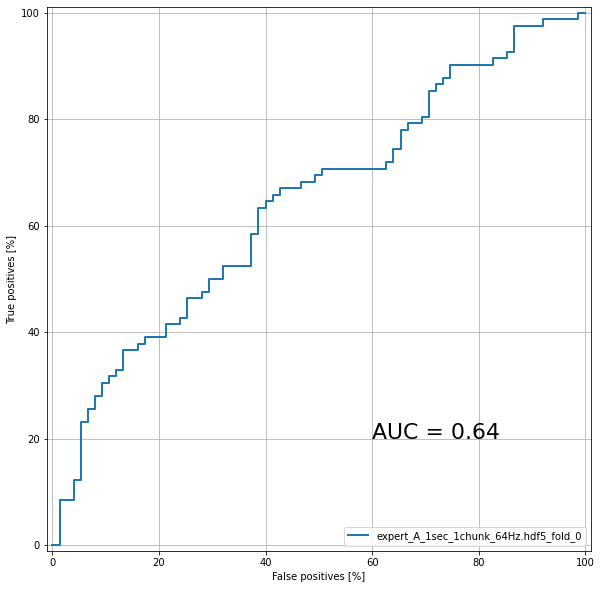

In [ ]:
# Read a sample best model
best_model_str = WRK_DIR + "best_models/best_model_{}_fold_{}.hdf5".format(data_name_no_ext, fold_number)
my_shape = np.expand_dims(x, axis = 3).shape
my_shape[1:]
model, model_description = build_CNN_model(my_shape)
model.load_weights(best_model_str, by_name = False)

#######################################################
# Evaluate our model on the test data
#######################################################
test_loss, test_acc = model.evaluate(x_test_3d, y_test, batch_size = 16, verbose = 0)
print('test_acc:', round(test_acc, 4))
print('test_loss:', round(test_loss, 4))

predictions = model.predict(x_test_3d, verbose = 0)

mpl.rcParams['figure.figsize'] = (10, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

name = data_name + '_fold_' + str(fold_number)
plot_roc_curve(name, y_test, predictions, save_to_file = False, color = colors[0])
cm = confusion_matrix(y_test, predictions > 0.5)
cmtx = pd.DataFrame(
    confusion_matrix(y_test, predictions > 0.5, labels = [0, 1]),
    index = ['true: seizure', 'true: no seizure'],
    columns = ['pred: seizure', 'pred: no seizure']
)
print(cmtx)
precision = cm[0,0] / (cm[0,0] + cm[1,0])
recall = cm[0,0] / (cm[0,0] + cm[0,1])
F_measure = 2 * ((precision * recall) / (precision + recall))

print('\n')
out = 'Precision: ' + str(round(precision, 4))
print(out)
out = 'Recall: ' + str(round(recall, 4))
print(out)
out = 'F-measure: ' + str(round(F_measure, 4))
print(out)

## Plot training and validation history

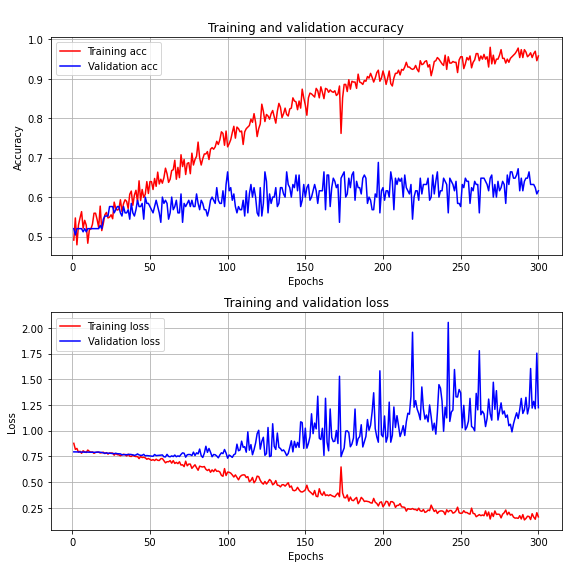

In [ ]:
# Change the file name to the correct one
hist_str = WRK_DIR + "hists/history_{}_fold_{}.pckl".format(data_name_no_ext, fold_number)
with open(hist_str, 'rb') as f:
    history = pickle.load(f)
    #f.close()

# if save_to_file = False, any string can be given as file_name variable
plot_acc_loss('any-string-can-be-given-here', history, save_to_file = False)

## Plot data as 2D images

On the upper figure a seizure chunk is depicted. On the lower figure a non-seizure chunk is depicted. Do you see any particular difference between the pictures? Probably sometimes yes and sometimes not. The individual chunks are chosen randomly.

[Text(0, 0.5, ''), Text(0.5, 0, 'Datapoints')]

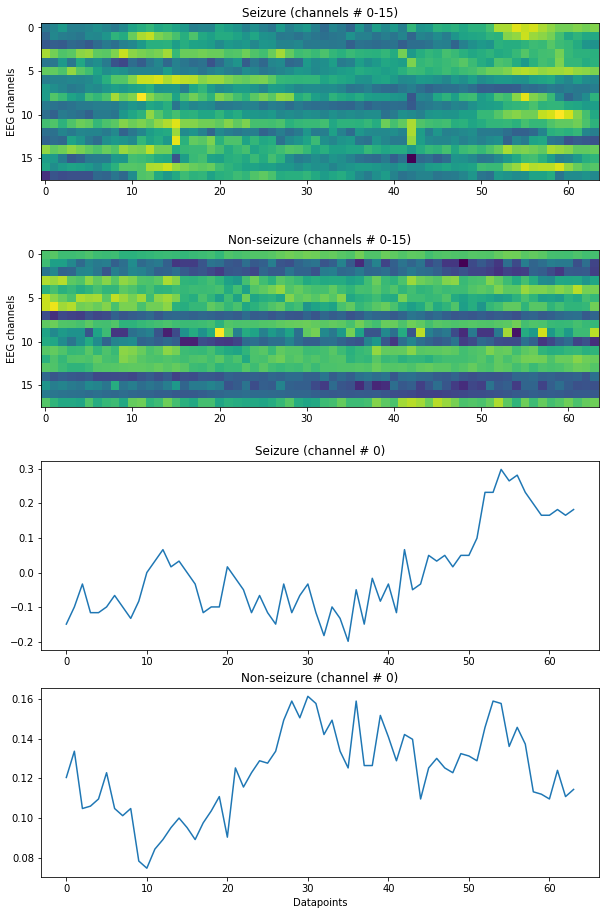

In [ ]:
arr_1 = np.where(y == 1)
arr_0 = np.where(y == 0)
N_1 = randrange(arr_1[0][0], arr_1[0][-1])
N_0 = randrange(arr_0[0][0], arr_0[0][-1])

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4)
fig.set_size_inches(10, 16)

# For using other colormaps, see https://matplotlib.org/stable/tutorials/colors/colormaps.html

# color
ax1.imshow(np.transpose(x[N_1,:,:]))
ax2.imshow(np.transpose(x[N_0,:,:]))

# B&W
#ax1.imshow(np.transpose(x[N_1,:,:]), plt.get_cmap("tab10"))
#ax2.imshow(np.transpose(x[N_0,:,:]), cmap=plt.cm.binary)

ax3.plot(x[N_1,:,0])
ax4.plot(x[N_0,:,0])

ax1.set_title("Seizure (channels # 0-15)")
ax1.set(xlabel = '', ylabel = 'EEG channels')

ax2.set_title("Non-seizure (channels # 0-15)")
ax2.set(xlabel = '', ylabel = 'EEG channels')

ax3.set_title("Seizure (channel # 0)")
ax3.set(xlabel = '', ylabel = '')

ax4.set_title("Non-seizure (channel # 0)")
ax4.set(xlabel = 'Datapoints', ylabel = '')

# Demonstrate how to use a pre-trained model to classify data other than that used to build the CNN network

**An important note**: you must be aware that our CNN network has been trained on a certain dataset (quite specific) and is ready to recognize a certain type of seizures (i.e. neonatals ones). Therefore, it should not be expected that when we provide completely different data to the pre-trained CNN network (e.g. based on elderly patients), the network will correctly classify the data. Also some technical details on EEG recordings must be considered carefully. In our case, signals from 18 EEG channels connected according to the 'double banana' montage were fed to the CNN network. When the new data is not analogous, the classification results can be very questionable. Nevertheless, when the new data is compatible (in the sense as stated above), there are no major contraindications to feed them to our pre-trained CNN network.

As a new dataset, i.e. one that was not used to build and train the CNN network, we will use EEG signals from neonates where there was no consensus between experts. 17 neonates had a seizure annotated by only 1 or 2 experts (infants No. `2`, `6`, `8`, `12`, `23`, `24`, `26`, `33`, `43`, `46`, `54`, `56`, `61`, `64`, `65`, `68`, `74`). Due to the
ambiguity in the expert opinion this subset was excluded from the process of building CNNs.

For classification task we choose the infants where expert C annotated at least 1 seizure (infants No. `6`, `12`, `23`, `26`, `33`, `43`, `46`, `54`, `56`, `61`, `64`, `65`, `74` ), see Table 7 in the paper.

To avoid a conflict with the filenames (see `working\inputs` directory), the expert was marked `CC` instead of `C`.

## Step 1: read new dataset to be fed to the pre-trained CNN network.

A *new dataset*, i.e. one that was not used to build and train the CNN network

In [ ]:
freq = FREQ
which_expert = "CC"
window = 10
chunks = 20

data_name = "expert_{}_{}sec_{}chunk_{}Hz.hdf5".format(which_expert, window, chunks, freq)

ds = 1
size = int(freq * window / ds)
file_h5 = h5py.File(INPUT_DIR + data_name, "r")
temp = file_h5["FINAL.mtx"]
temp = np.array(temp)
dd = np.transpose(temp)
dd.shape
ddss = dd[::ds]
dr = ddss.reshape(int(ddss.shape[0] / size), size, dd.shape[1])
x = dr[:,:,0:NO_OF_EEG_CHANELS]
y = dr[:,0,SEIZURE_INDICATOR - 1]
x = tf.keras.utils.normalize(x, axis = 1)

## Step 2: Read the pre-trained model

Note that the model must be compatible with the dataset we want to classify. The compatibility means that the window size must be the same both in the model and in the new dataset. In this example we use the model saved in the file `best_model_expert_C_10sec_10000chunk_64Hz_fold_0.hdf5` because the performance of this model is very good, see Tables 3, 4, 5 in the paper.

In [ ]:
# Read a sample best model
#best_model_str = WRK_DIR + "best_models/best_model_{}_fold_{}.hdf5".format(data_name_no_ext, fold_number)
best_model_str = WRK_DIR + "best_models/best_model_expert_C_10sec_10000chunk_64Hz_fold_0.hdf5"
my_shape = np.expand_dims(x, axis = 3).shape
my_shape[1:]
model, model_description = build_CNN_model(my_shape)
model.load_weights(best_model_str, by_name = False)

#model.summary()


## Step 3: run predict method

The obtained performance seems to be quite good.

                  pred: seizure  pred: no seizure
true: seizure               303                 5
true: no seizure             97               190


Presision: 0.7575
Recall:  0.9837662337662337
F measure:  0.8559322033898306


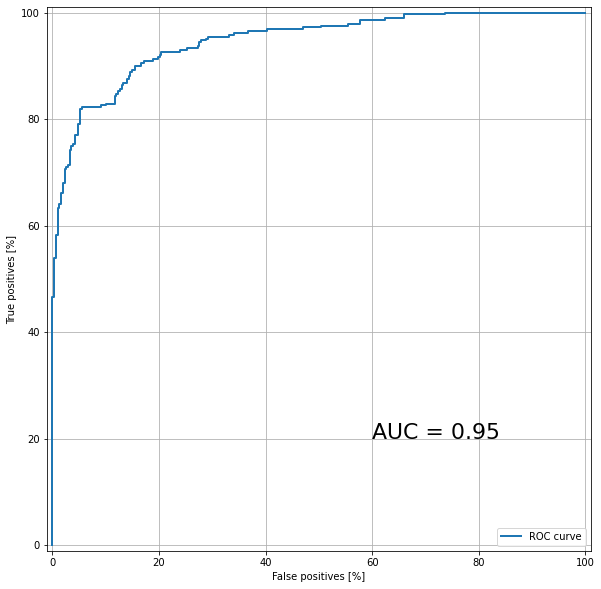

In [ ]:
x_3d = x
x_3d = np.expand_dims(x_3d, axis = 3)

predictions = model.predict(x_3d, verbose = 0)

cm = confusion_matrix(y, predictions > 0.5)
cmtx = pd.DataFrame(
    confusion_matrix(y, predictions > 0.5, labels = [0, 1]),
    index = ['true: seizure', 'true: no seizure'],
    columns = ['pred: seizure', 'pred: no seizure']
)
precision = cm[0,0] / (cm[0,0] + cm[1,0])
recall = cm[0,0] / (cm[0,0] + cm[0,1])
F_measure = 2 * ((precision * recall) / (precision + recall))

print(cmtx)
print("\n")
print("Presision:", precision)
print("Recall: ", recall)
print("F measure: ", F_measure)

mpl.rcParams['figure.figsize'] = (10, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plot_roc_curve("ROC curve", y, predictions, save_to_file = False, color = colors[0])
